In [1]:
import pennylane as qml
from pennylane import numpy as np

In [2]:
DATA_QBITS = 4
LATENT_QBITS = 2
TRASH_QBITS = DATA_QBITS - LATENT_QBITS
TOTAL_QBITS = DATA_QBITS + TRASH_QBITS + 1

In [3]:
dev1 = qml.device('default.qubit', wires=TOTAL_QBITS)

In [7]:
def layer(params, wires):
    for i in range(len(wires)):
        qml.RY(params[i], wires=i)
    for i in range(len(wires)):
        for j in range(i+1, len(wires)):
            qml.CNOT(wires=[i, j])

@qml.qnode(dev1)
def circuit(enc_params,layers, data):
    for i,j in enumerate(data):
        qml.RX(j,wires=i)
    for i in range(layers):
        layer(enc_params[i*DATA_QBITS:(i+1)*DATA_QBITS], np.arange(0,DATA_QBITS))
    qml.Hadamard(wires=TOTAL_QBITS-1)
    for i in range(TRASH_QBITS):
        #c += cirq.ControlledGate(sub_gate=cirq.SWAP, num_controls=1).on(swap_qbit, reference_qbits[i], network_qbits[num_data_qbits - num_latent_qbits:][i])
        qml.CSWAP(wires=[TOTAL_QBITS - 1, LATENT_QBITS + i, DATA_QBITS + i])
    qml.Hadamard(wires=TOTAL_QBITS-1)
    return qml.expval(qml.PauliZ(TOTAL_QBITS-1))

/tmp/ipykernel_303447/3189985478.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


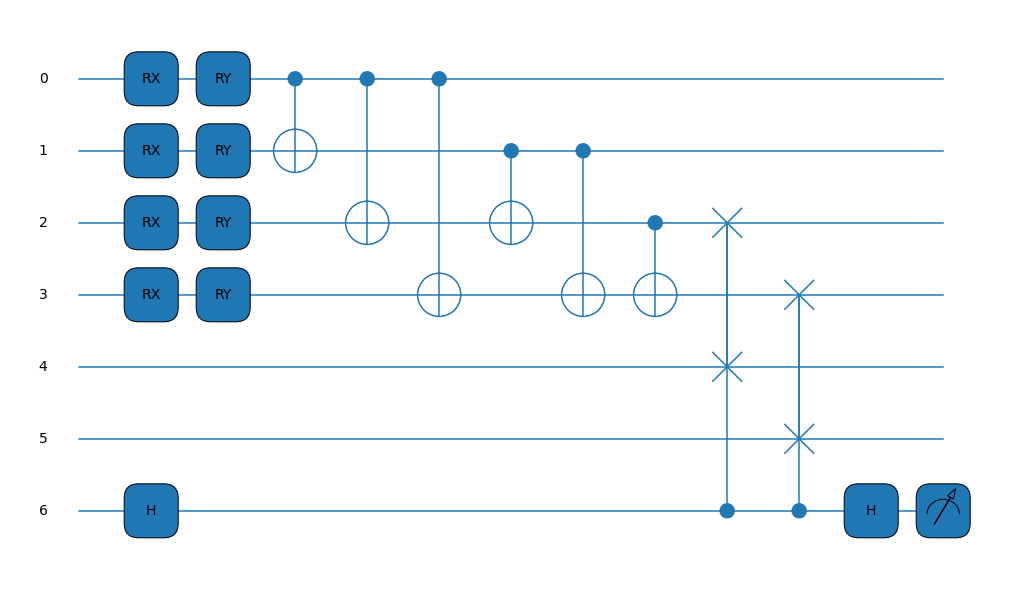

In [8]:
fig, ax = qml.draw_mpl(circuit)([1,1,1,1],1,[0.1,0.24,0.3,0.14])
fig.show()

In [9]:
import matplotlib.pyplot as plt
from hep_VQAE import data_preprocessing as dp
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

2022-07-16 16:35:00.761580: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-16 16:35:00.762028: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [10]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0

In [11]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

In [12]:
DOWNSCALE = 2
DATA_DIMENSION = DOWNSCALE*DOWNSCALE
LATENT_BITS = 2

x_train, x_test = dp.PCA_reduce(x_train, DATA_DIMENSION, val_data=x_test)

In [13]:
x_train_threes = np.array(x_train[y_train==True])
x_train = np.array(x_train[y_train==False])

x_test_threes = np.array(x_test[y_test==True])
x_test = np.array(x_test[y_test==False])

In [14]:
LAYERS = 5

def cost(params, X):
    loss = 0.0
    for i in range(len(X)):
        f = circuit(params, LAYERS, X[i])
        loss = loss + (1 - f) ** 2
    return loss / len(X)

In [15]:
def iterate_minibatches(data, batch_size):
    for start_idx in range(0, data.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield data[idxs]

In [16]:
learning_rate = 0.1
epochs = 5
batch_size = 64

In [19]:
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
#opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
opt = qml.QNGOptimizer(learning_rate)
#opt = GradientDescentOptimizer(learning_rate)

In [20]:
params = np.random.uniform(size=LAYERS*4, requires_grad=True)


In [21]:
params.shape

(20,)

In [22]:
x_train.shape

(5918, 4)

In [ ]:
for it in range(epochs):
    for j,Xbatch in enumerate(iterate_minibatches(x_train, batch_size=batch_size)):
        metric_tensor_fn = qml.metric_tensor(circuit, approx='block-diag')
        params, _ = opt.step(cost, params, Xbatch,metric_tensor_fn=metric_tensor_fn(params,LAYERS,Xbatch))
        print(j, end="\r")

    loss = cost(params, x_train)
    
    print(f"Epoch: {it} | Loss: {loss} |")